# **Projet Apprentissage Machine:** Analyse de performance académique
## Student Performance Dataset – Kaggle

### **Objectif du projet:**
1. Régression pour prédire les notes finales en mathématiques
2. Classification binaire (succès vs échec du test preparation course)
3. Clustering des profils d'étudiants
4. Méthodes d'ensemble pour combiner les prédictions

### **Description du jeu de données:**
Jeu de données contenant les notes d'étudiants du secondaire aux États-Unis, avec l'influence du contexte familial sur les performances académiques.

**Variables:**
- `gender` - (female, male)
- `race/ethnicity` - (group A, B, C, D, E)
- `parental level of education` - (some high school, high school, some college, associate's degree, bachelor's degree, master's degree)
- `lunch` - (standard, free/reduced)
- `test preparation course` - (none, completed)
- `math score` - (0 à 100)
- `reading score` - (17 à 100)
- `writing score` - (10 à 100)

---

## **1. Chargement et préparation des données**
### **Objectifs de cette section:**
1. Nettoyage, encodage des variables catégorielles et normalisation
2. Gestion des valeurs manquantes
3. Analyse descriptive des données

### **Initialisation et configuration**

In [75]:
# ============================================
# IMPORTS ESSENTIELS
# ============================================
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.decomposition import PCA

# Modèles
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Utilitaires
import random
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURATION DE LA REPRODUCTIBILITÉ
# ============================================
SEED = 42
random.seed(SEED)
np.random.seed(seed=SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
plt.style.use('seaborn-v0_8-darkgrid')

### **1.1 Chargement des données**

In [3]:
# Chargement du dataset depuis le fichier CSV
df = pd.read_csv("../data/StudentsPerformance.csv")

# Affichage des 10 premières lignes pour inspection
print(f"Dimensions du dataset: {df.shape}")
print(f"Nombre d'observations: {df.shape[0]}")
print(f"Nombre de variables: {df.shape[1]}\n")

df.head(10)

Dimensions du dataset: (1000, 8)
Nombre d'observations: 1000
Nombre de variables: 8



,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


### **1.2 Analyse initiale et nettoyage**

In [4]:
print("=== INFORMATION SUR LES DONNÉES ===")
df.info()

=== INFORMATION SUR LES DONNÉES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
print("\n=== VALEURS MANQUANTES ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Aucune valeur manquante détectée")



=== VALEURS MANQUANTES ===
Aucune valeur manquante détectée


In [6]:
print("\n=== DOUBLONS ===")
duplicates = df.duplicated().sum()
print(f"Nombre de doublons: {duplicates}")


=== DOUBLONS ===
Nombre de doublons: 0


In [7]:
print("\n=== STATISTIQUES DESCRIPTIVES ===")
df.describe().round(2)


=== STATISTIQUES DESCRIPTIVES ===


,math score,reading score,writing score
count,1000.00,1000.00,1000.00
mean,66.09,69.17,68.05
std,15.16,14.60,15.20
min,0.00,17.00,10.00
25%,57.00,59.00,57.75
50%,66.00,70.00,69.00
75%,77.00,79.00,79.00
max,100.00,100.00,100.00


In [8]:
print("\n=== NOMBRE DE VALEURS UNIQUES PAR VARIABLE ===")
df.nunique()


=== NOMBRE DE VALEURS UNIQUES PAR VARIABLE ===


gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

### **1.3 Identification des types de variables**

In [9]:
# Séparation automatique des variables catégorielles et numériques
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

In [10]:
print("Variables catégorielles:", categorical_cols)
print("Variables numériques:", numerical_cols)
print("\nVariable cible pour la classification: 'test preparation course'")

Variables catégorielles: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Variables numériques: ['math score', 'reading score', 'writing score']

Variable cible pour la classification: 'test preparation course'


### **1.4 Encodage des variables catégorielles**

In [11]:
# Copie des données catégorielles pour transformation
categorical_df = df[categorical_cols].copy()

# Afficher les modalités uniques pour chaque variable catégorielle
print("Modalités uniques par variable catégorielle:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Modalités uniques par variable catégorielle:
gender: ['female' 'male']
race/ethnicity: ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch: ['standard' 'free/reduced']
test preparation course: ['none' 'completed']


### **Encodage One-Hot pour variables nominales**

In [12]:
# Variables à encoder en one-hot (pas d'ordre naturel)
one_hot_cols = ['gender', 'lunch']

# Application du one-hot encoding
categorical_df = pd.get_dummies(categorical_df, columns=one_hot_cols, dtype=int)

print(f"Après one-hot encoding, shape: {categorical_df.shape}")
categorical_df.head()

Après one-hot encoding, shape: (1000, 7)


,race/ethnicity,parental level of education,test preparation course,gender_female,gender_male,lunch_free/reduced,lunch_standard
0,group B,bachelor's degree,none,1,0,0,1
1,group C,some college,completed,1,0,0,1
2,group B,master's degree,none,1,0,0,1
3,group A,associate's degree,none,0,1,1,0
4,group C,some college,none,0,1,0,1


### **Encodage ordinal pour niveau d'éducation**

In [13]:
# Définition de l'ordre hiérarchique des niveaux d'éducation
education_order = [
    "some high school",      # Niveau 0
    "high school",           # Niveau 1
    "some college",          # Niveau 2
    "associate's degree",    # Niveau 3
    "bachelor's degree",     # Niveau 4
    "master's degree"        # Niveau 5
]

In [14]:
# Application de l'encodage ordinal
ordinal_encoder = OrdinalEncoder(categories=[education_order], dtype=int)
categorical_df['parental level of education'] = ordinal_encoder.fit_transform(
    categorical_df[['parental level of education']]
)

In [15]:
print("Encodage ordinal appliqué. Mapping:")
for i, level in enumerate(education_order):
    print(f"  {i}: {level}")


Encodage ordinal appliqué. Mapping:
  0: some high school
  1: high school
  2: some college
  3: associate's degree
  4: bachelor's degree
  5: master's degree


### **Encodage par fréquence pour ethnicity**

In [16]:
# Encodage par fréquence relative pour race/ethnicity
ethnicity_freq = df['race/ethnicity'].value_counts(normalize=True)
categorical_df['race/ethnicity'] = df['race/ethnicity'].map(ethnicity_freq)

print("Fréquences relatives par groupe ethnique:")
print(ethnicity_freq.round(3))

Fréquences relatives par groupe ethnique:
race/ethnicity
group C    0.319
group D    0.262
group B    0.190
group E    0.140
group A    0.089
Name: proportion, dtype: float64


### **1.5 Fusion et normalisation des données**

In [17]:
# ============================================
# FUSION DES DONNÉES TRANSFORMÉES
# ============================================
# Combinaison des données catégorielles encodées et numériques
clean_df = pd.concat([categorical_df, df[numerical_cols]], axis=1)

print(f"Dimensions finales après nettoyage: {clean_df.shape}")
print("\nAperçu des données nettoyées:")
clean_df.head()

Dimensions finales après nettoyage: (1000, 10)

Aperçu des données nettoyées:


,race/ethnicity,parental level of education,test preparation course,gender_female,gender_male,lunch_free/reduced,lunch_standard,math score,reading score,writing score
0,0.190,4,none,1,0,0,1,72,72,74
1,0.319,2,completed,1,0,0,1,69,90,88
2,0.190,5,none,1,0,0,1,90,95,93
3,0.089,3,none,0,1,1,0,47,57,44
4,0.319,2,none,0,1,0,1,76,78,75


### **Normalisation avec MinMaxScaler**

In [21]:
# Normalisation Min-Max (valeurs entre 0 et 1)
minmax_scaler = MinMaxScaler()
minmax_scaler.set_output(transform="pandas")

# Exclure `test preparation course` - cible
data_minmax = minmax_scaler.fit_transform(clean_df.drop(columns=['test preparation course']))

print("Données normalisées avec MinMaxScaler (aperçu):")
data_minmax.head()

Données normalisées avec MinMaxScaler (aperçu):


,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,math score,reading score,writing score
0,0.43913,0.8,1.0,0.0,0.0,1.0,0.72,0.662651,0.711111
1,1.00000,0.4,1.0,0.0,0.0,1.0,0.69,0.879518,0.866667
2,0.43913,1.0,1.0,0.0,0.0,1.0,0.90,0.939759,0.922222
3,0.00000,0.6,0.0,1.0,1.0,0.0,0.47,0.481928,0.377778
4,1.00000,0.4,0.0,1.0,0.0,1.0,0.76,0.734940,0.722222


### **Standardisation avec StandardScaler**

In [22]:
# Standardisation (moyenne=0, écart-type=1)
std_scaler = StandardScaler()
std_scaler.set_output(transform="pandas")

# Exclure `test preparation course` - cible
data_standardized = std_scaler.fit_transform(clean_df.drop(columns=['test preparation course']))

print("Données standardisées avec StandardScaler (aperçu):")
data_standardized.head()

Données standardisées avec StandardScaler (aperçu):


,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,math score,reading score,writing score
0,-0.569024,1.314742,0.964625,-0.964625,-0.741881,0.741881,0.390024,0.193999,0.391492
1,1.098265,-0.055495,0.964625,-0.964625,-0.741881,0.741881,0.192076,1.427476,1.313269
2,-0.569024,1.999860,0.964625,-0.964625,-0.741881,0.741881,1.577711,1.770109,1.642475
3,-1.874421,0.629624,-1.036672,1.036672,1.347925,-1.347925,-1.259543,-0.833899,-1.583744
4,1.098265,-0.055495,-1.036672,1.036672,-0.741881,0.741881,0.653954,0.605158,0.457333


### **1.6 Visualisation de la distribution après prétraitement**

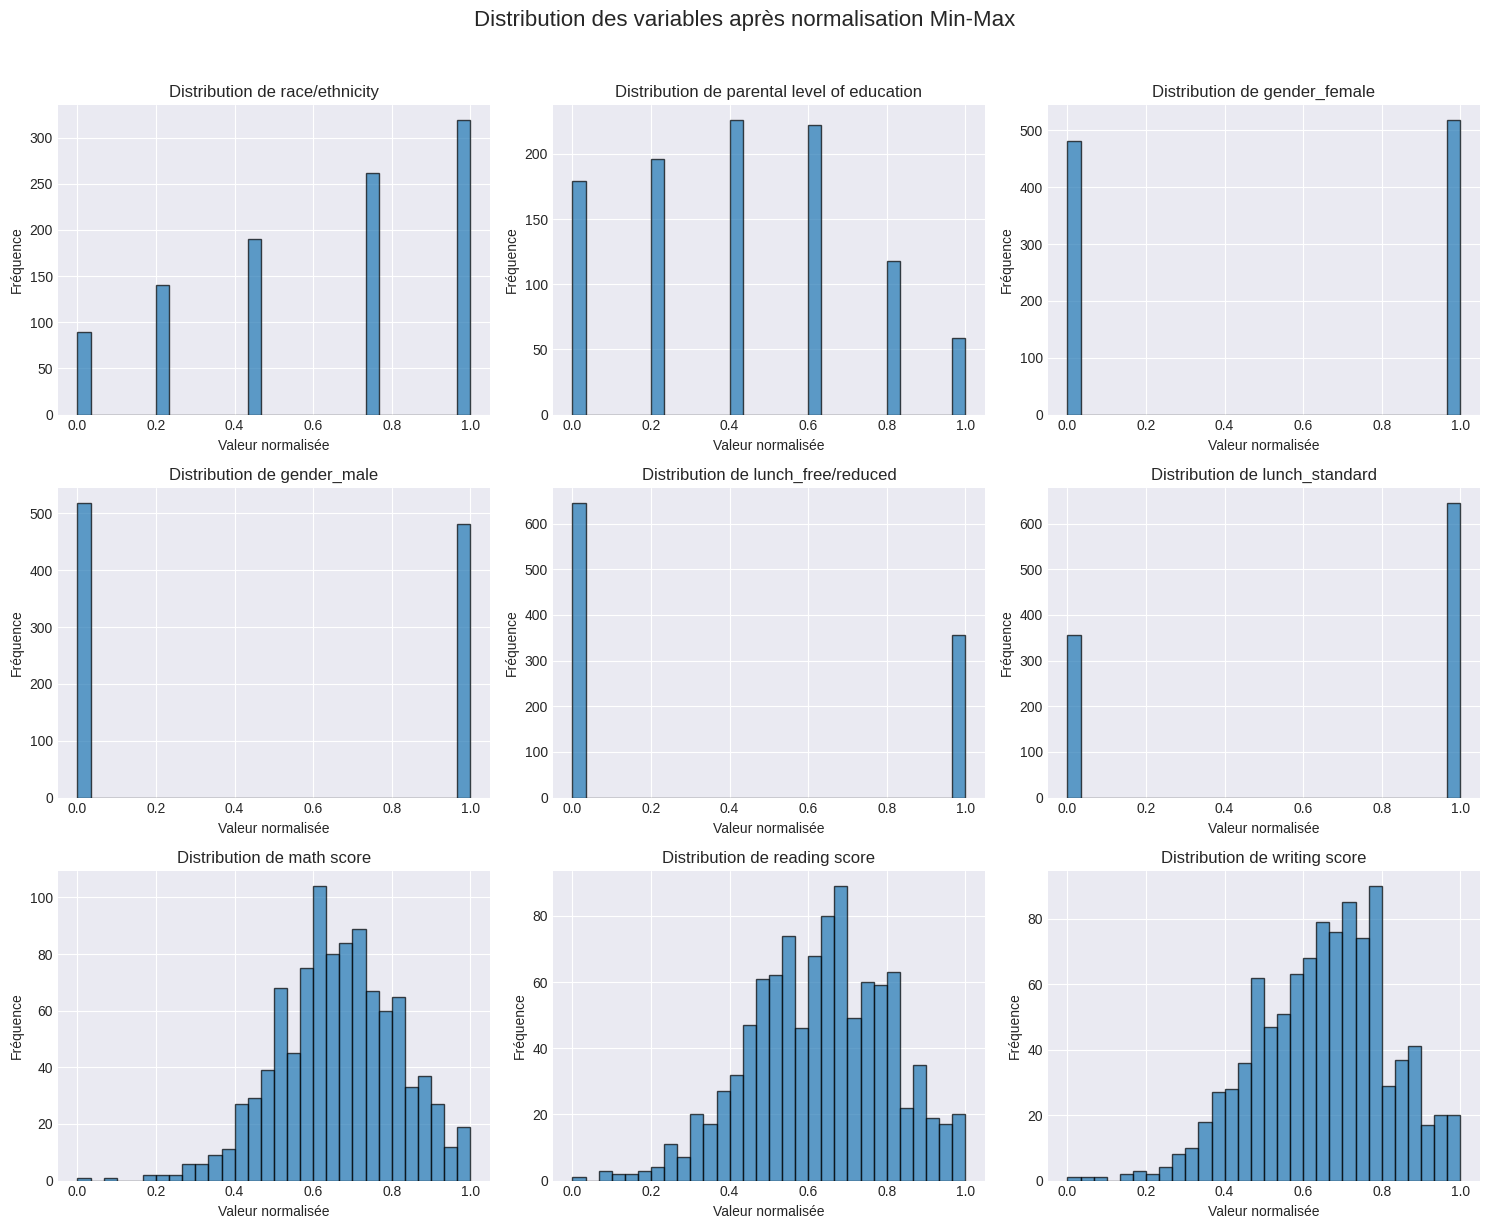

In [23]:
# Distribution des données après normalisation
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(data_minmax.columns[:9]):  # Limité aux 9 premières colonnes
    axes[i].hist(data_minmax[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution de {col}')
    axes[i].set_xlabel('Valeur normalisée')
    axes[i].set_ylabel('Fréquence')

plt.suptitle('Distribution des variables après normalisation Min-Max', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **2. Analyse exploratoire et visualisation**

### **2.1 Distribution des scores par matière**

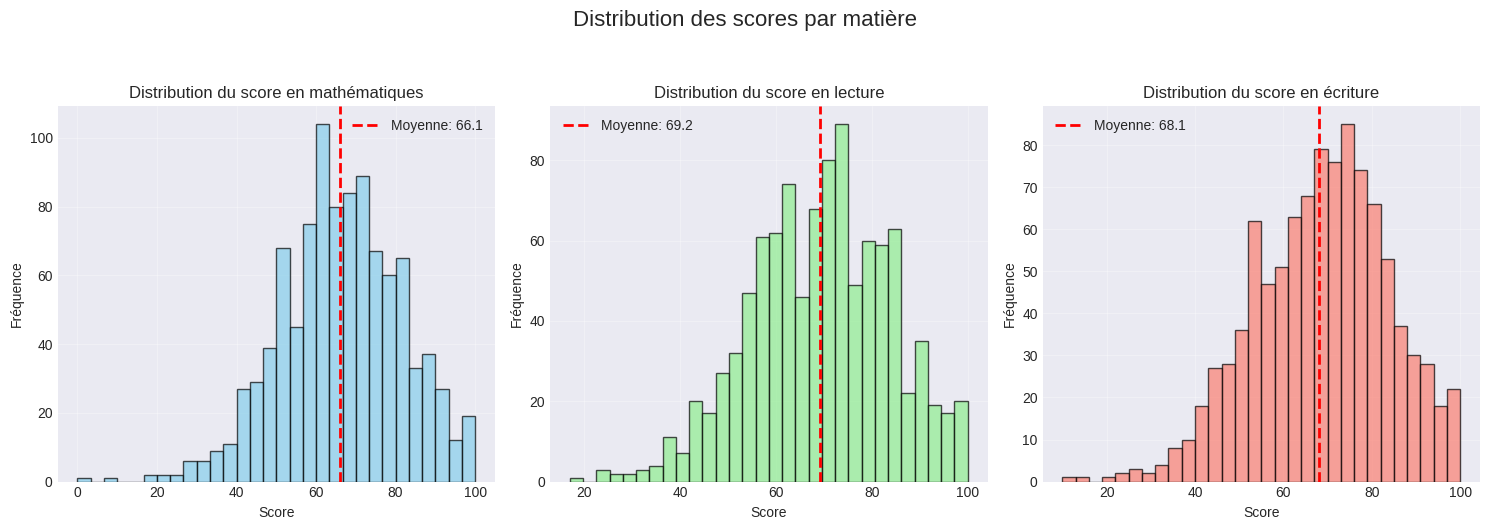

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Math score
axes[0].hist(df['math score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(df['math score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["math score"].mean():.1f}')
axes[0].set_title('Distribution du score en mathématiques')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Fréquence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reading score
axes[1].hist(df['reading score'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(df['reading score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["reading score"].mean():.1f}')
axes[1].set_title('Distribution du score en lecture')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Writing score
axes[2].hist(df['writing score'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[2].axvline(df['writing score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["writing score"].mean():.1f}')
axes[2].set_title('Distribution du score en écriture')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Fréquence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Distribution des scores par matière', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### **2.2 Matrice de corrélation**

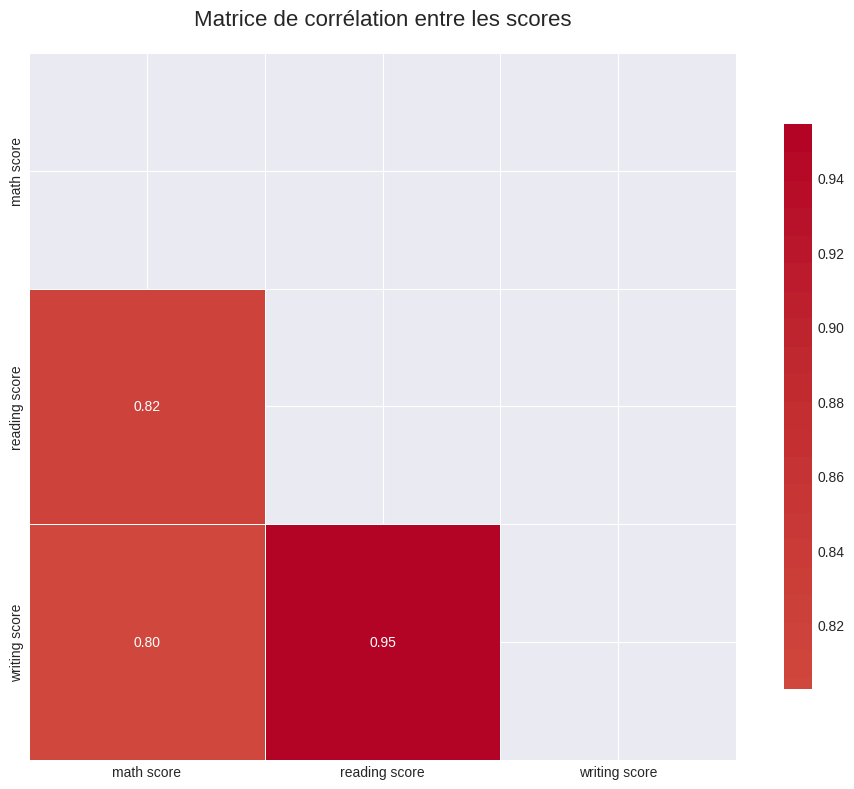

In [89]:
# Calcul de la matrice de corrélation
correlation_matrix = df[numerical_cols].corr()

# Visualisation avec heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

plt.title('Matrice de corrélation entre les scores', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [90]:
# Observations sur les corrélations
print("Observations clés sur les corrélations:")
print(f"1. Corrélation lecture-écriture: {correlation_matrix.loc['reading score', 'writing score']:.3f}")
print(f"2. Corrélation math-lecture: {correlation_matrix.loc['math score', 'reading score']:.3f}")
print(f"3. Corrélation math-écriture: {correlation_matrix.loc['math score', 'writing score']:.3f}")

Observations clés sur les corrélations:
1. Corrélation lecture-écriture: 0.955
2. Corrélation math-lecture: 0.818
3. Corrélation math-écriture: 0.803


### **2.3 Distribution des variables catégorielles**

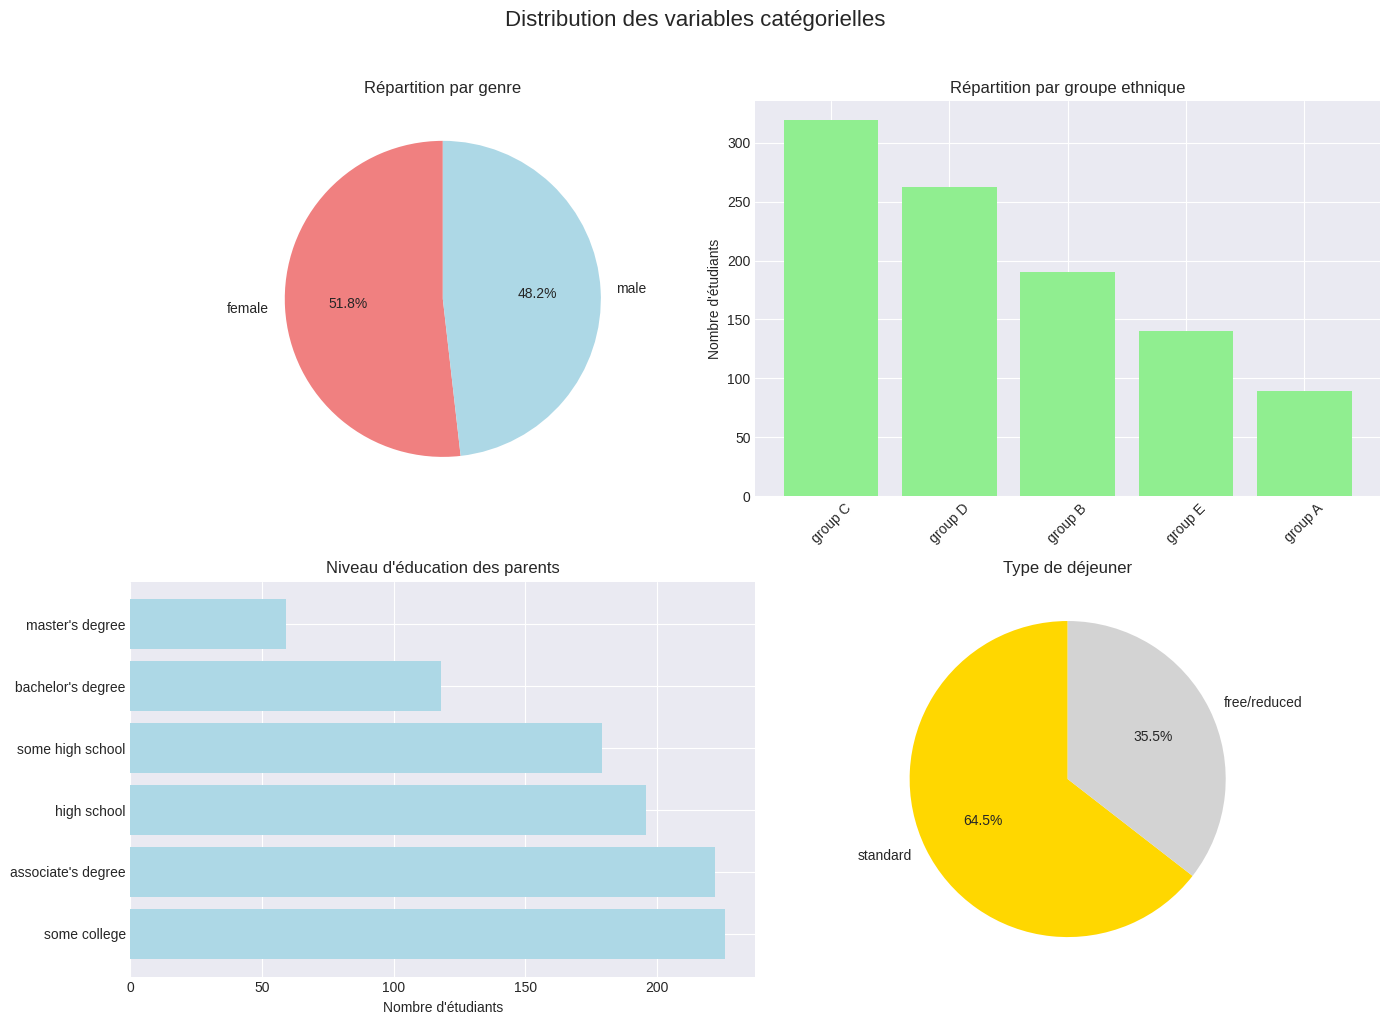

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution par genre
gender_counts = df['gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
               startangle=90, colors=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Répartition par genre')

# Distribution par groupe ethnique
ethnicity_counts = df['race/ethnicity'].value_counts()
axes[0, 1].bar(ethnicity_counts.index, ethnicity_counts.values, color='lightgreen')
axes[0, 1].set_title('Répartition par groupe ethnique')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel('Nombre d\'étudiants')

# Distribution par niveau d'éducation des parents
education_counts = df['parental level of education'].value_counts()
axes[1, 0].barh(education_counts.index, education_counts.values, color='lightblue')
axes[1, 0].set_title('Niveau d\'éducation des parents')
axes[1, 0].set_xlabel('Nombre d\'étudiants')

# Distribution par type de lunch
lunch_counts = df['lunch'].value_counts()
axes[1, 1].pie(lunch_counts.values, labels=lunch_counts.index, autopct='%1.1f%%',
               startangle=90, colors=['gold', 'lightgray'])
axes[1, 1].set_title('Type de déjeuner')

plt.suptitle('Distribution des variables catégorielles', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **2.4 Relation entre variables catégorielles et scores**

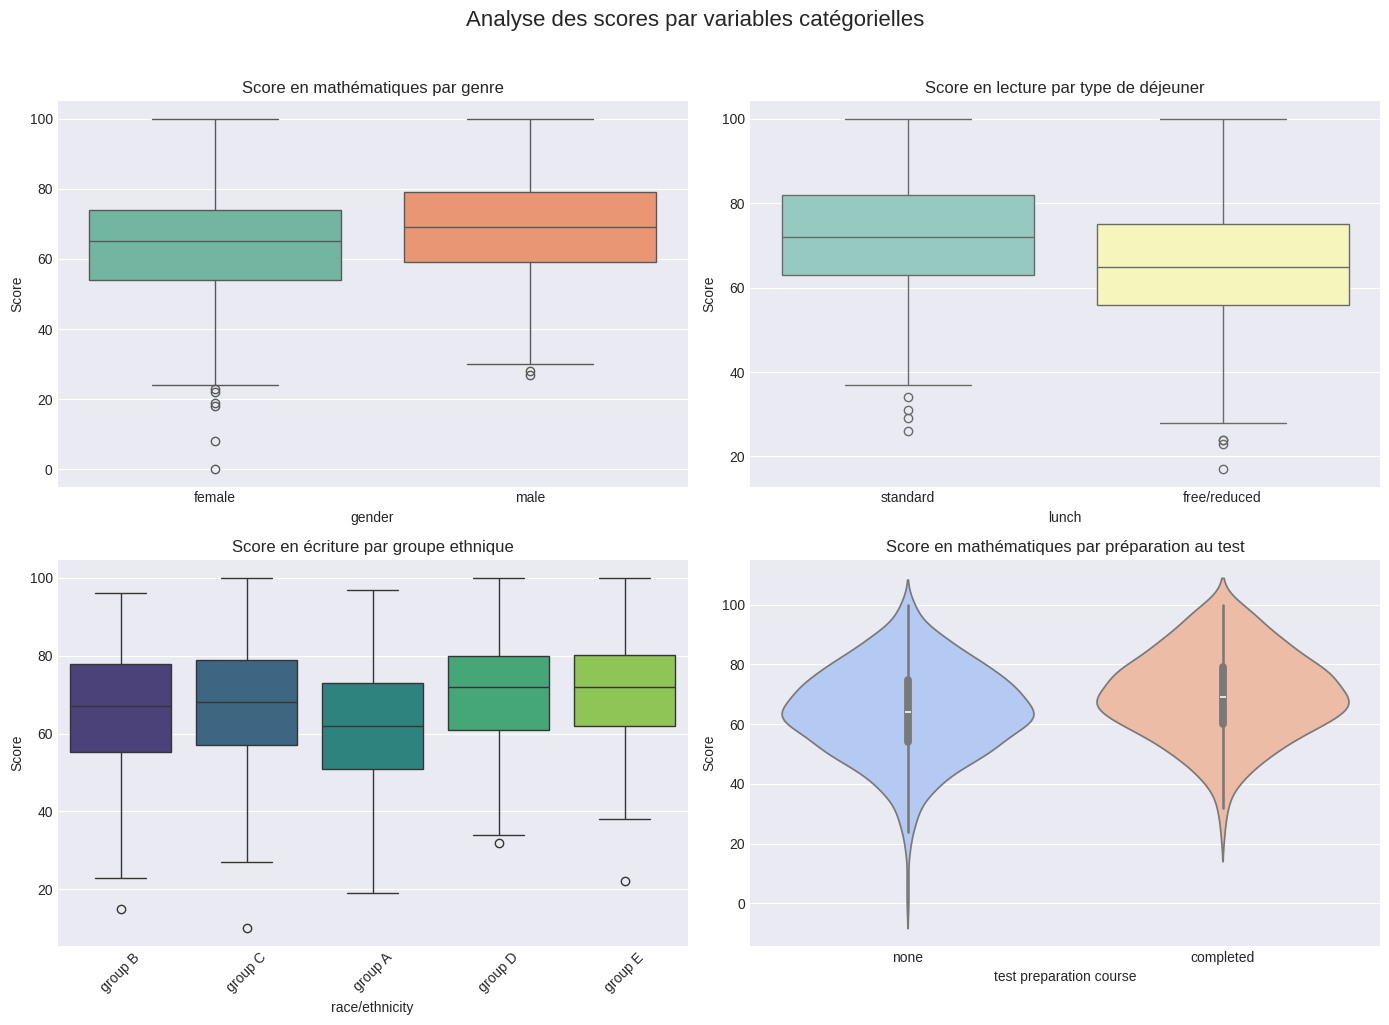

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot: Scores par genre
sns.boxplot(data=df, x='gender', y='math score', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Score en mathématiques par genre')
axes[0, 0].set_ylabel('Score')

sns.boxplot(data=df, x='lunch', y='reading score', ax=axes[0, 1], palette='Set3')
axes[0, 1].set_title('Score en lecture par type de déjeuner')
axes[0, 1].set_ylabel('Score')

# Boxplot: Scores par groupe ethnique
sns.boxplot(data=df, x='race/ethnicity', y='writing score', ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Score en écriture par groupe ethnique')
axes[1, 0].set_ylabel('Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Violin plot: Scores par préparation au test
sns.violinplot(data=df, x='test preparation course', y='math score', ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Score en mathématiques par préparation au test')
axes[1, 1].set_ylabel('Score')

plt.suptitle('Analyse des scores par variables catégorielles', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **2.5 Nuage de points avec régression linéaire**

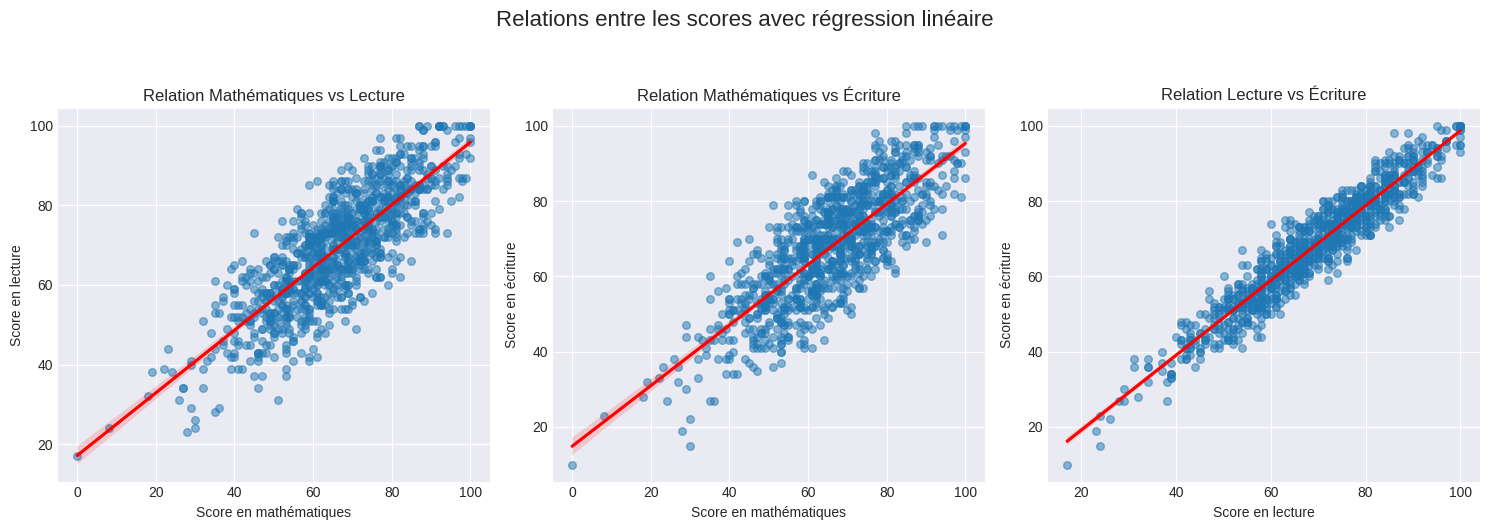

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Math vs Reading
sns.regplot(data=df, x='math score', y='reading score', ax=axes[0], 
            scatter_kws={'alpha':0.5, 's':30}, line_kws={'color':'red'})
axes[0].set_title('Relation Mathématiques vs Lecture')
axes[0].set_xlabel('Score en mathématiques')
axes[0].set_ylabel('Score en lecture')

# Math vs Writing
sns.regplot(data=df, x='math score', y='writing score', ax=axes[1], 
            scatter_kws={'alpha':0.5, 's':30}, line_kws={'color':'red'})
axes[1].set_title('Relation Mathématiques vs Écriture')
axes[1].set_xlabel('Score en mathématiques')
axes[1].set_ylabel('Score en écriture')

# Reading vs Writing
sns.regplot(data=df, x='reading score', y='writing score', ax=axes[2], 
            scatter_kws={'alpha':0.5, 's':30}, line_kws={'color':'red'})
axes[2].set_title('Relation Lecture vs Écriture')
axes[2].set_xlabel('Score en lecture')
axes[2].set_ylabel('Score en écriture')

plt.suptitle('Relations entre les scores avec régression linéaire', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### **3. Préparation pour la modélisation**

### **3.1 Séparation des données pour classification**

In [31]:
# Définition des variables et cible pour classification
y_class = df["test preparation course"].map({'none': 0, 'completed': 1})
X_class = df.drop(columns=["test preparation course", "math score"])  # On retire math score pour éviter les fuites

# Séparation train-test avec stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_class, y_class, test_size=0.25, random_state=SEED, stratify=y_class
)

print(f"Dimensions pour classification:")
print(f"  Train: {X_train_clf.shape}")
print(f"  Test:  {X_test_clf.shape}")
print(f"\nDistribution de la cible dans l'ensemble d'entraînement:")
print(y_train_clf.value_counts(normalize=True).round(3))

Dimensions pour classification:
  Train: (750, 6)
  Test:  (250, 6)

Distribution de la cible dans l'ensemble d'entraînement:
test preparation course
0    0.641
1    0.359
Name: proportion, dtype: float64


### **3.2 Pipeline de prétraitement**

In [32]:
# Définition des colonnes par type de transformation
one_hot_features = ['gender', 'lunch', 'race/ethnicity']
ordinal_features = ['parental level of education']
numeric_features = ['reading score', 'writing score']

# Préprocesseur pour classification
preprocessor_clf = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),
        ('ordinal', OrdinalEncoder(categories=[education_order]), ordinal_features),
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# Application du prétraitement
X_train_clf_processed = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor_clf.transform(X_test_clf)

print(f"Données après prétraitement - Classification:")
print(f"  Shape train: {X_train_clf_processed.shape}")
print(f"  Shape test:  {X_test_clf_processed.shape}")

Données après prétraitement - Classification:
  Shape train: (750, 9)
  Shape test:  (250, 9)


### **3.3 Séparation des données pour régression**

In [33]:
# Définition des variables et cible pour régression
y_reg = df["math score"]
X_reg = df.drop(columns=["math score", "test preparation course"])

# Séparation train-test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=SEED
)

print(f"Dimensions pour régression:")
print(f"  Train: {X_train_reg.shape}")
print(f"  Test:  {X_test_reg.shape}")
print(f"\nStatistiques de la cible (math score):")
print(f"  Moyenne train: {y_train_reg.mean():.2f}")
print(f"  Écart-type train: {y_train_reg.std():.2f}")

Dimensions pour régression:
  Train: (800, 6)
  Test:  (200, 6)

Statistiques de la cible (math score):
  Moyenne train: 66.50
  Écart-type train: 15.02


### **3.4 Pipeline pour régression**

In [34]:
# Préprocesseur pour régression (identique mais sans la variable cible)
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), one_hot_features),
        ('ordinal', OrdinalEncoder(categories=[education_order]), ordinal_features),
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# Application du prétraitement
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

print(f"Données après prétraitement - Régression:")
print(f"  Shape train: {X_train_reg_processed.shape}")
print(f"  Shape test:  {X_test_reg_processed.shape}")

Données après prétraitement - Régression:
  Shape train: (800, 9)
  Shape test:  (200, 9)


### **4. Modélisation supervisée - Classification**

### **4.1 Fonction d'évaluation des modèles**

In [35]:
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name=""):
    """
    Évalue un modèle de classification et retourne les métriques principales
    """
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        'Modèle': model_name,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Précision Test': precision_score(y_test, y_pred_test, zero_division=0),
        'Rappel Test': recall_score(y_test, y_pred_test, zero_division=0),
        'F1-Score Test': f1_score(y_test, y_pred_test, zero_division=0)
    }
    
    return metrics, y_pred_test

### **4.2 Entraînement des modèles de base**

In [36]:
# Initialisation des modèles
models_clf = {
    'SVM Linéaire': SVC(kernel='linear', random_state=SEED, probability=True),
    'Arbre de Décision': DecisionTreeClassifier(random_state=SEED, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=SEED)
}

# Évaluation de chaque modèle
results_clf = []
predictions = {}

for name, model in models_clf.items():
    metrics, y_pred = evaluate_classification_model(
        model, X_train_clf_processed, X_test_clf_processed, 
        y_train_clf, y_test_clf, name
    )
    results_clf.append(metrics)
    predictions[name] = y_pred

# Création du DataFrame des résultats
results_df_clf = pd.DataFrame(results_clf)
results_df_clf = results_df_clf.sort_values('Accuracy Test', ascending=False)

print("Résultats des modèles de classification:")
print(results_df_clf.round(4).to_string(index=False))

Résultats des modèles de classification:
           Modèle  Accuracy Train  Accuracy Test  Précision Test  Rappel Test  F1-Score Test
     SVM Linéaire          0.6960          0.752          0.7015       0.5281         0.6026
    Random Forest          0.9973          0.680          0.5570       0.4944         0.5238
Gradient Boosting          0.8200          0.660          0.5286       0.4157         0.4654
Arbre de Décision          0.7213          0.636          0.4857       0.3820         0.4277


### **4.3 Visualisation des performances**

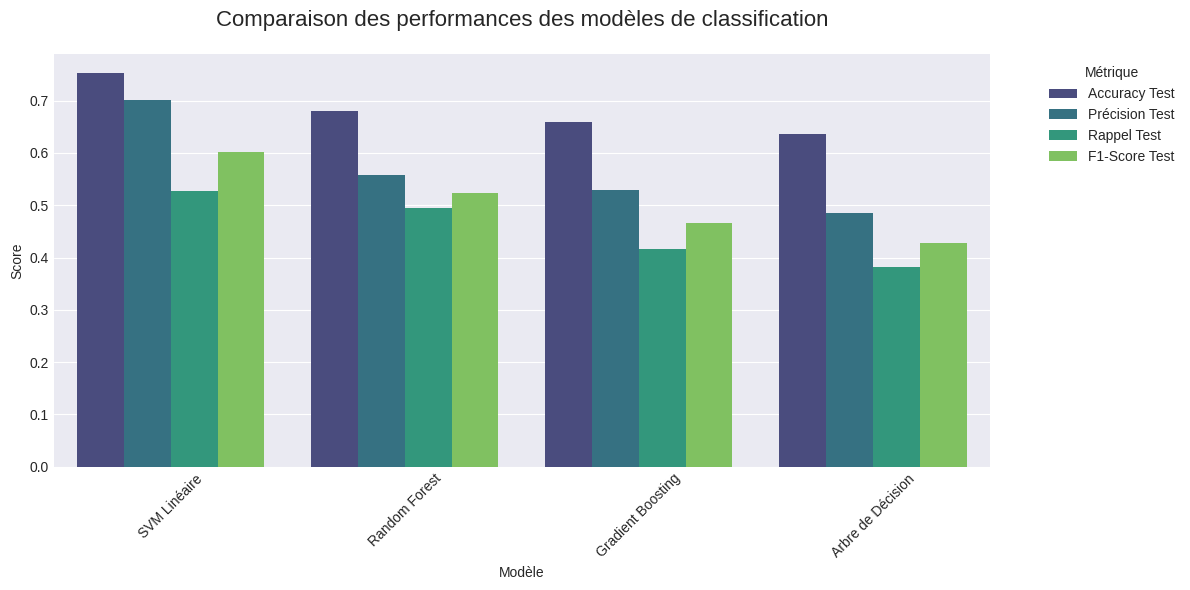

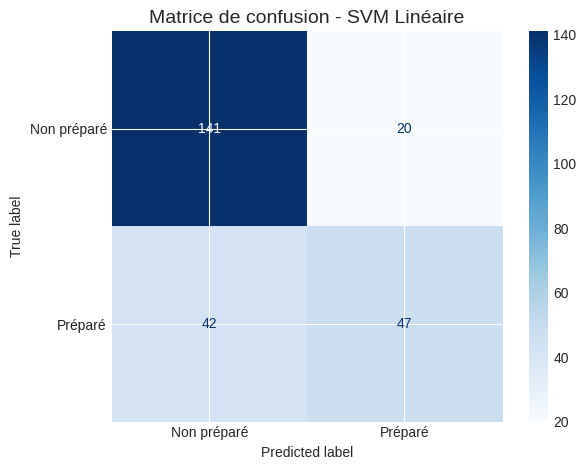

In [37]:
# Préparation des données pour la visualisation
plot_data = results_df_clf.melt(id_vars=['Modèle'], 
                                 value_vars=['Accuracy Test', 'Précision Test', 'Rappel Test', 'F1-Score Test'],
                                 var_name='Métrique', value_name='Score')

# Graphique comparatif
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x='Modèle', y='Score', hue='Métrique', palette='viridis')
plt.title('Comparaison des performances des modèles de classification', fontsize=16, pad=20)
plt.ylabel('Score')
plt.xlabel('Modèle')
plt.xticks(rotation=45)
plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Matrice de confusion pour le meilleur modèle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model_name = results_df_clf.iloc[0]['Modèle']
best_predictions = predictions[best_model_name]

cm = confusion_matrix(y_test_clf, best_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non préparé', 'Préparé'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Matrice de confusion - {best_model_name}', fontsize=14)
plt.tight_layout()
plt.show()

### **4.4 Validation croisée**

In [39]:
# Validation croisée 5-fold
cv_scores = {}
for name, model in models_clf.items():
    scores = cross_val_score(model, X_train_clf_processed, y_train_clf, 
                            cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores[name] = scores



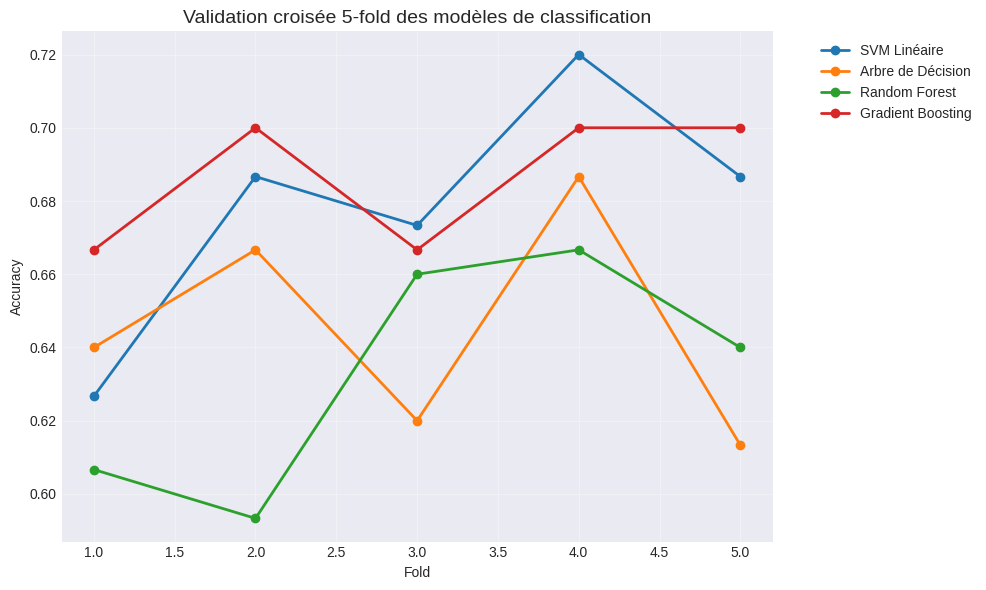

In [40]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(10, 6))
for name, scores in cv_scores.items():
    plt.plot(range(1, 6), scores, marker='o', label=name, linewidth=2)

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Validation croisée 5-fold des modèles de classification', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [41]:
# Résumé statistique
print("Résumé de la validation croisée (moyenne ± écart-type):")
for name, scores in cv_scores.items():
    print(f"  {name}: {scores.mean():.3f} ± {scores.std():.3f}")

Résumé de la validation croisée (moyenne ± écart-type):
  SVM Linéaire: 0.679 ± 0.030
  Arbre de Décision: 0.645 ± 0.028
  Random Forest: 0.633 ± 0.029
  Gradient Boosting: 0.687 ± 0.016


### **5. Modélisation supervisée - Régression**

### **5.1 Fonction d'évaluation des modèles de régression**

In [45]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name=""):
    """
    Évalue un modèle de régression et retourne les métriques principales
    """
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        'Modèle': model_name,
        'R² Train': r2_score(y_train, y_pred_train),
        'R² Test': r2_score(y_test, y_pred_test),
        'RMSE Train': root_mean_squared_error(y_train, y_pred_train),
        'RMSE Test': root_mean_squared_error(y_test, y_pred_test),
        'MAE Test': mean_squared_error(y_test, y_pred_test)
    }
    
    return metrics, y_pred_test

### **5.2 Entraînement des modèles de régression**

In [46]:
# Initialisation des modèles
models_reg = {
    'Régression Linéaire': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=SEED),
    'Lasso Regression': Lasso(alpha=0.1, random_state=SEED, max_iter=5000),
    'Random Forest Reg': RandomForestRegressor(n_estimators=100, random_state=SEED)
}

# Évaluation de chaque modèle
results_reg = []
predictions_reg = {}

for name, model in models_reg.items():
    metrics, y_pred = evaluate_regression_model(
        model, X_train_reg_processed, X_test_reg_processed,
        y_train_reg, y_test_reg, name
    )
    results_reg.append(metrics)
    predictions_reg[name] = y_pred

# Création du DataFrame des résultats
results_df_reg = pd.DataFrame(results_reg)
results_df_reg = results_df_reg.sort_values('R² Test', ascending=False)

print("Résultats des modèles de régression:")
print(results_df_reg.round(4).to_string(index=False))

Résultats des modèles de régression:
             Modèle  R² Train  R² Test  RMSE Train  RMSE Test  MAE Test
   Lasso Regression    0.8639   0.8692      5.5397     5.6414   31.8254
   Ridge Regression    0.8649   0.8670      5.5194     5.6882   32.3554
Régression Linéaire    0.8649   0.8670      5.5192     5.6887   32.3619
  Random Forest Reg    0.9748   0.8286      2.3827     6.4574   41.6975


### **5.3 Visualisation des performances en régression**

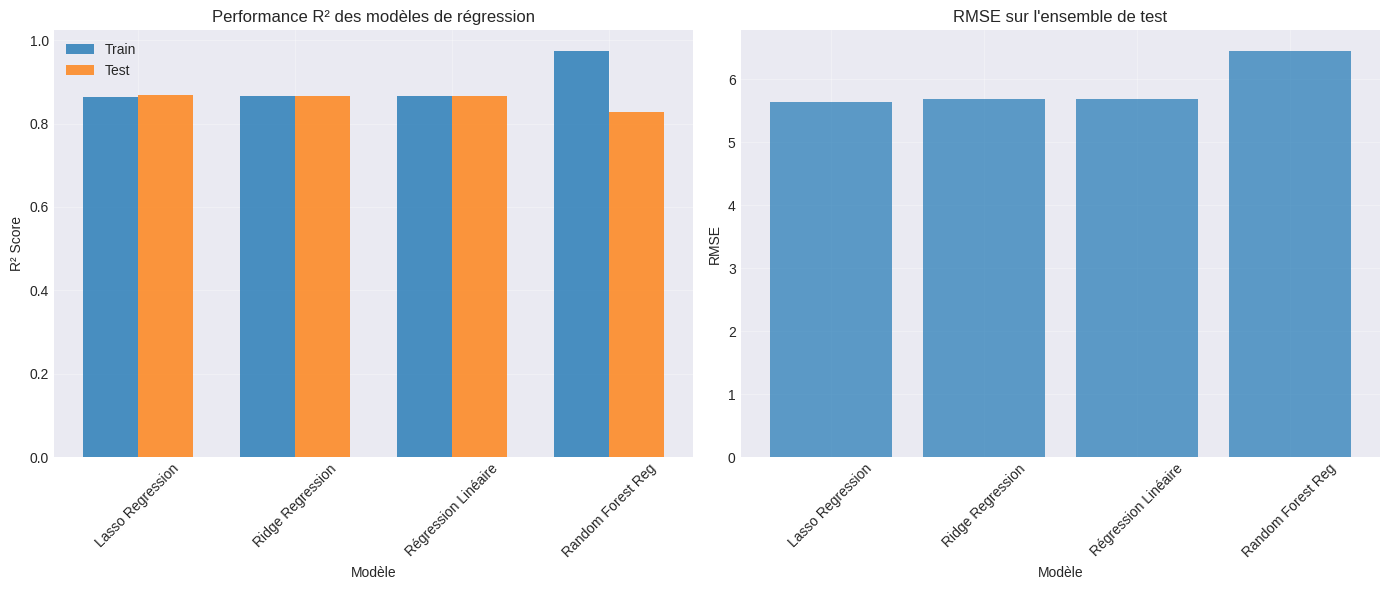

In [47]:
# Graphique comparatif des R²
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² scores
models = results_df_reg['Modèle']
r2_test = results_df_reg['R² Test']
r2_train = results_df_reg['R² Train']

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, r2_train, width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, r2_test, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Performance R² des modèles de régression')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE scores
rmse_test = results_df_reg['RMSE Test']

axes[1].bar(models, rmse_test, alpha=0.7)
axes[1].set_xlabel('Modèle')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE sur l\'ensemble de test')
axes[1].set_xticklabels(models, rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **5.4 Analyse des prédictions vs valeurs réelles**

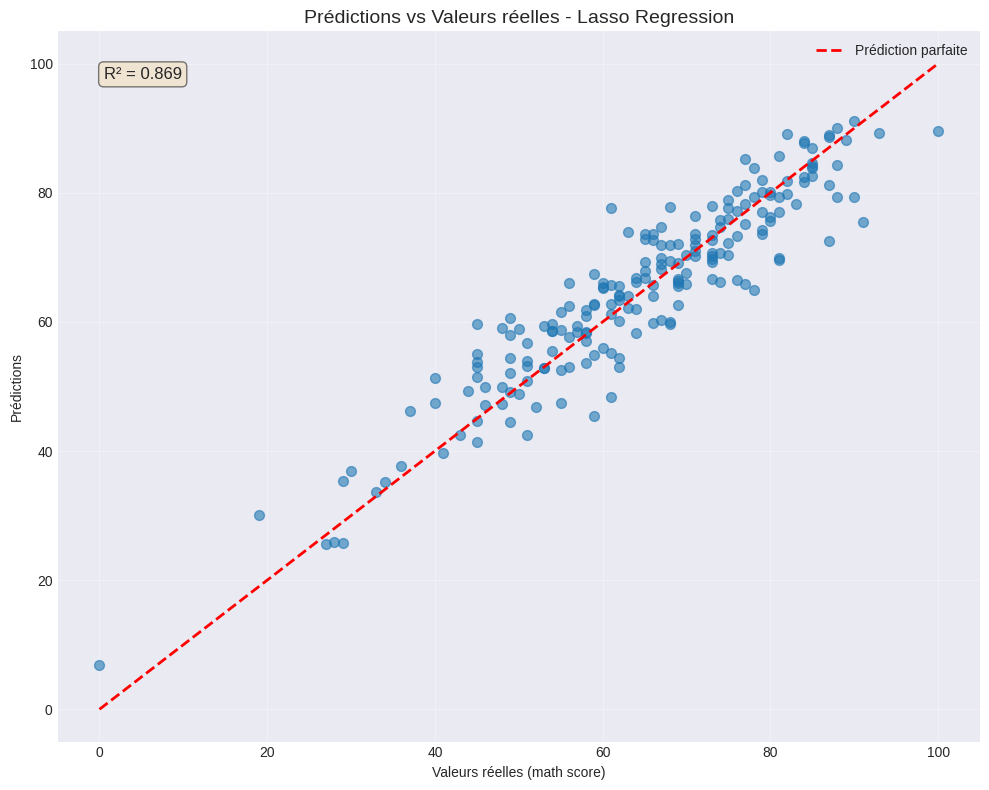

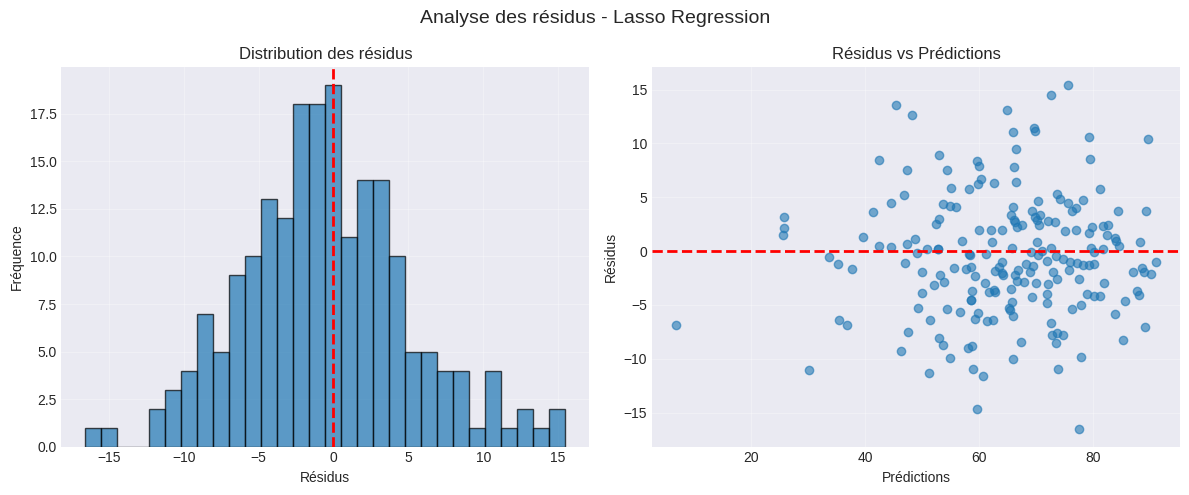

In [48]:
# Graphique des prédictions vs valeurs réelles pour le meilleur modèle
best_reg_model = results_df_reg.iloc[0]['Modèle']
y_pred_best = predictions_reg[best_reg_model]

plt.figure(figsize=(10, 8))
plt.scatter(y_test_reg, y_pred_best, alpha=0.6, s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Prédiction parfaite')

plt.xlabel('Valeurs réelles (math score)')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Valeurs réelles - {best_reg_model}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Ajouter le coefficient de détermination
r2 = r2_score(y_test_reg, y_pred_best)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Analyse des résidus
residuals = y_test_reg - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme des résidus
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Résidus')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des résidus')
axes[0].grid(True, alpha=0.3)

# Plot des résidus
axes[1].scatter(y_pred_best, residuals, alpha=0.6)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Résidus')
axes[1].set_title('Résidus vs Prédictions')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Analyse des résidus - {best_reg_model}', fontsize=14)
plt.tight_layout()
plt.show()

# **6. Clustering (Analyse non supervisée)**

### **6.1 Préparation des données pour le clustering**

In [49]:
# Sélection des features pour le clustering
features_clustering = ['math score', 'reading score', 'writing score']

# Normalisation des données
scaler_clustering = StandardScaler()
X_cluster = scaler_clustering.fit_transform(df[features_clustering])

print(f"Données pour clustering: {X_cluster.shape}")

Données pour clustering: (1000, 3)


### **6.2 Méthode du coude pour déterminer le nombre optimal de clusters**

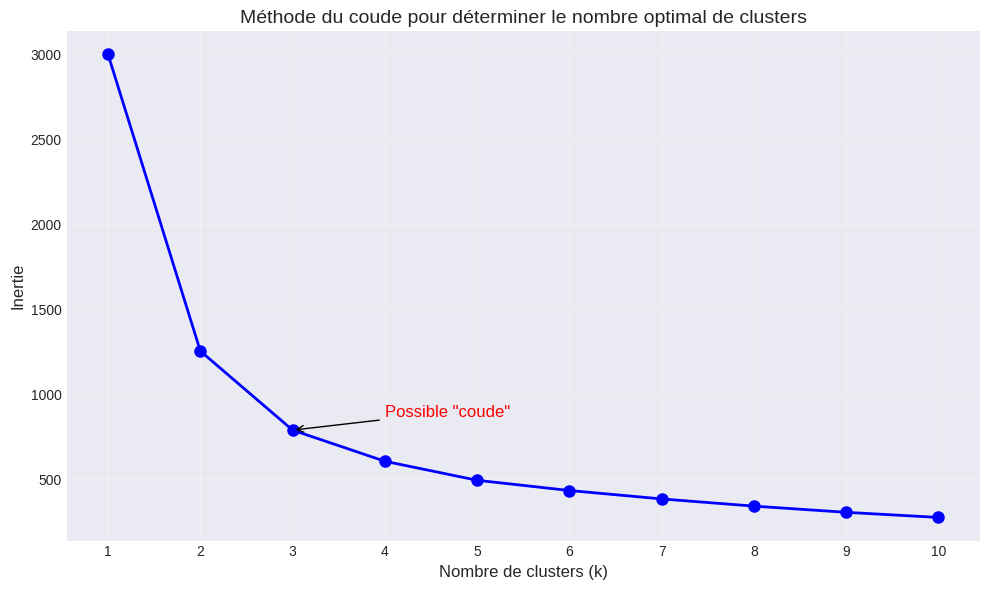

In [50]:
# Calcul de l'inertie pour différentes valeurs de k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Graphique de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Inertie', fontsize=12)
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Ajout des annotations pour les points d'inflexion
plt.annotate('Possible "coude"', xy=(3, inertia[2]), xytext=(4, inertia[2]*1.1),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, color='red')

plt.tight_layout()
plt.show()

### **6.3 Application du K-Means avec k optimal**

In [51]:
# Choix du nombre de clusters (basé sur la méthode du coude)
optimal_k = 3

# Application du K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=SEED, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

# Ajout des labels au dataframe original
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

print(f"Répartition des clusters:")
print(df_clustered['Cluster'].value_counts().sort_index())

Répartition des clusters:
Cluster
0    443
1    249
2    308
Name: count, dtype: int64


### **6.4 Visualisation des clusters**

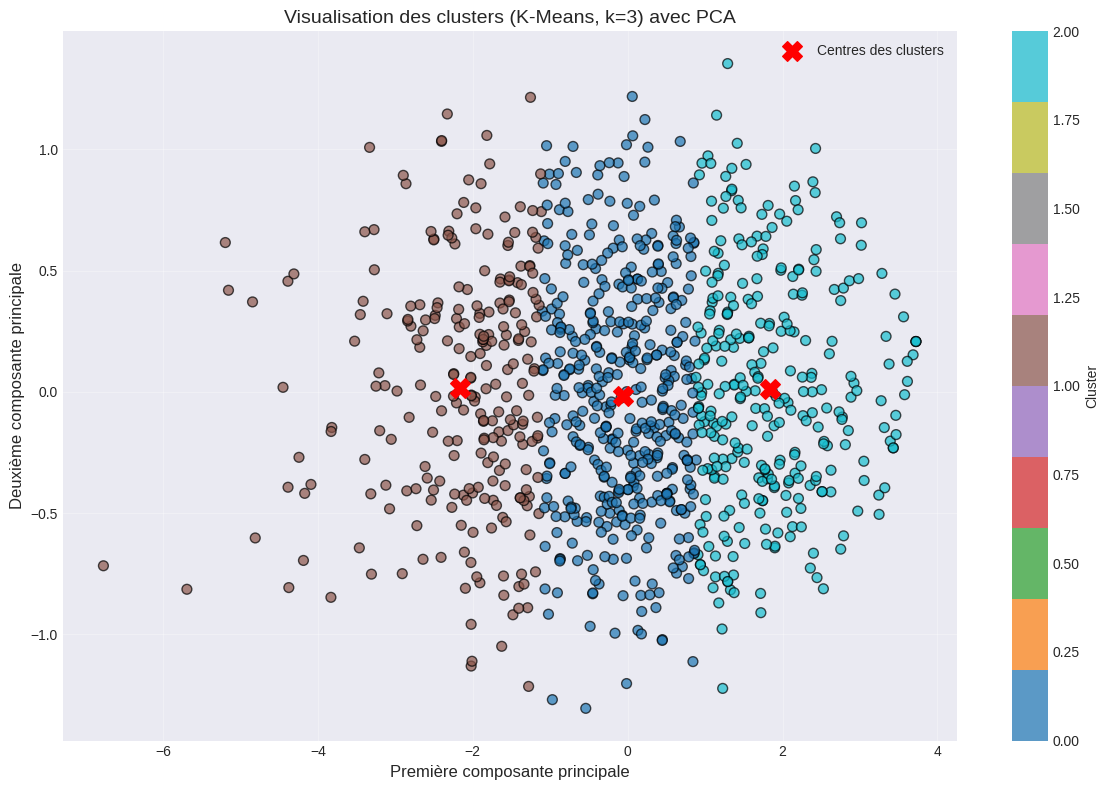

In [52]:
# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# Création du scatter plot coloré par cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=cluster_labels, cmap='tab10', 
                     s=50, alpha=0.7, edgecolor='black')

# Ajout des centres de clusters dans l'espace PCA
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='X', s=200, label='Centres des clusters')

plt.xlabel('Première composante principale', fontsize=12)
plt.ylabel('Deuxième composante principale', fontsize=12)
plt.title(f'Visualisation des clusters (K-Means, k={optimal_k}) avec PCA', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **6.5 Analyse des caractéristiques des clusters**

In [54]:
# Analyse des moyennes par cluster
cluster_analysis = df_clustered.groupby('Cluster')[features_clustering].mean()

print("Moyennes des scores par cluster:")
print(cluster_analysis.round(2))



Moyennes des scores par cluster:
         math score  reading score  writing score
Cluster                                          
0             65.34          68.46          67.82
1             48.10          50.67          48.49
2             81.71          85.15          84.21


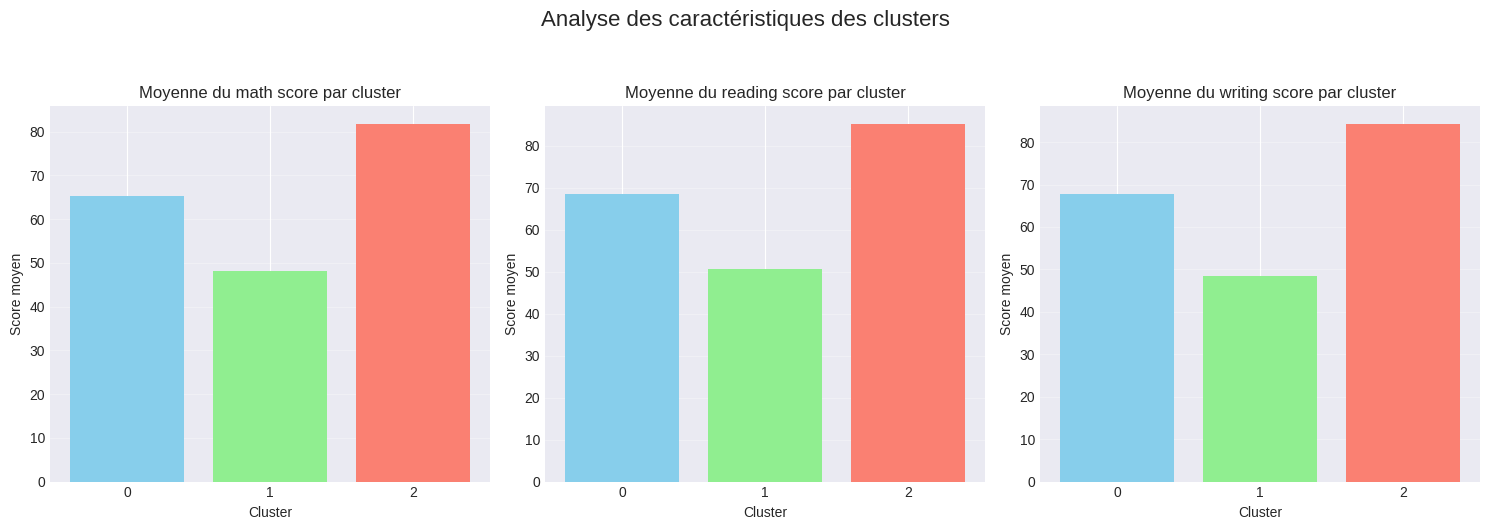

In [55]:
# Visualisation des moyennes par cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(features_clustering):
    cluster_means = cluster_analysis[feature]
    axes[idx].bar(cluster_means.index, cluster_means.values, color=['skyblue', 'lightgreen', 'salmon'])
    axes[idx].set_title(f'Moyenne du {feature} par cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Score moyen')
    axes[idx].set_xticks(cluster_means.index)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Analyse des caractéristiques des clusters', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



In [56]:
# Profilage des clusters
print("\nProfil des clusters:")
for cluster_id in range(optimal_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    print(f"  Score moyen en math: {cluster_data['math score'].mean():.1f}")
    print(f"  Score moyen en lecture: {cluster_data['reading score'].mean():.1f}")
    print(f"  Score moyen en écriture: {cluster_data['writing score'].mean():.1f}")


Profil des clusters:

Cluster 0 (n=443):
  Score moyen en math: 65.3
  Score moyen en lecture: 68.5
  Score moyen en écriture: 67.8

Cluster 1 (n=249):
  Score moyen en math: 48.1
  Score moyen en lecture: 50.7
  Score moyen en écriture: 48.5

Cluster 2 (n=308):
  Score moyen en math: 81.7
  Score moyen en lecture: 85.1
  Score moyen en écriture: 84.2


### **6.6 Comparaison avec d'autres méthodes de clustering**

<u>Implémentation des méthodes suivantes:</u>
1. DBSCAN
2. Agglomératif Hiérarchique

In [57]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_cluster)

In [58]:
# Clustering hiérarchique agglomératif
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_labels = agglo.fit_predict(X_cluster)

In [59]:
# Calcul des scores de silhouette
from sklearn.metrics import silhouette_score

silhouette_scores = {
    'K-Means': silhouette_score(X_cluster, cluster_labels),
    'DBSCAN': silhouette_score(X_cluster, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else -1,
    'Agglomeratif': silhouette_score(X_cluster, agglo_labels)
}

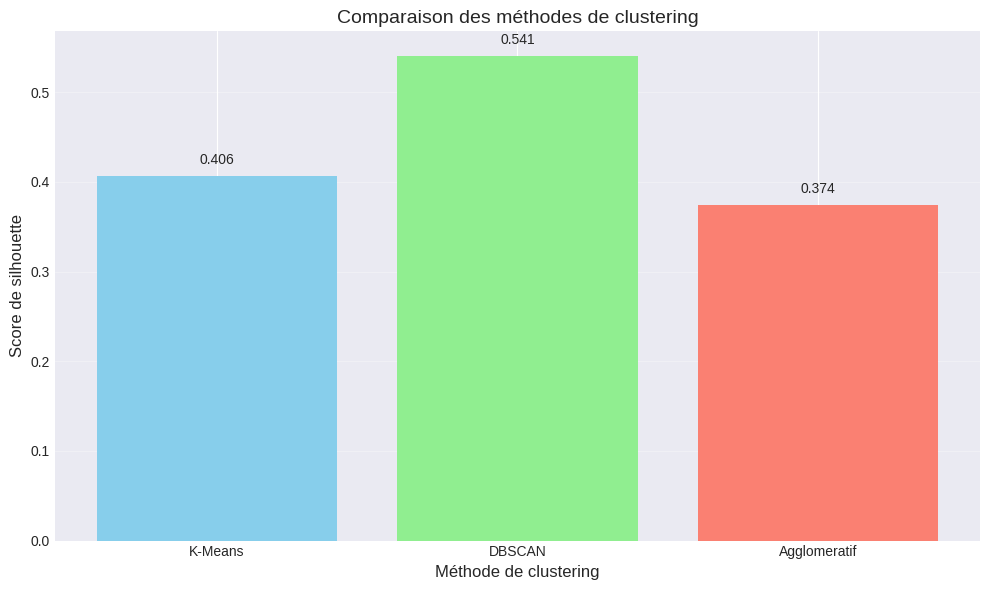

In [60]:
# Visualisation comparative
methods = list(silhouette_scores.keys())
scores = list(silhouette_scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Méthode de clustering', fontsize=12)
plt.ylabel('Score de silhouette', fontsize=12)
plt.title('Comparaison des méthodes de clustering', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [61]:
print("\nScores de silhouette:")
for method, score in silhouette_scores.items():
    print(f"  {method}: {score:.3f}")


Scores de silhouette:
  K-Means: 0.406
  DBSCAN: 0.541
  Agglomeratif: 0.374


# **7. Méthodes d'ensemble**

### **7.1 Initialisation des modèles d'ensemble**

In [76]:
# Modèles d'ensemble pour classification
ensemble_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=SEED),
    'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                           n_estimators=50, random_state=SEED),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0  # Pour réduire les messages d'avertissement
    )
}

In [77]:
# Fonction pour entraîner et évaluer plusieurs modèles
def train_and_evaluate_ensemble(models_dict, X_train, X_test, y_train, y_test):
    """
    Entraîne et évalue plusieurs modèles d'ensemble
    """
    results = []
    
    for name, model in models_dict.items():
        print(f"Entraînement du modèle: {name}")
        
        # Entraînement
        model.fit(X_train, y_train)
        
        # Prédictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calcul des métriques
        metrics = {
            'Modèle': name,
            'Accuracy Train': accuracy_score(y_train, y_pred_train),
            'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Précision Test': precision_score(y_test, y_pred_test, zero_division=0),
            'Rappel Test': recall_score(y_test, y_pred_test, zero_division=0),
            'F1-Score Test': f1_score(y_test, y_pred_test, zero_division=0)
        }
        
        results.append(metrics)
        
        print(f"  Accuracy test: {metrics['Accuracy Test']:.3f}")
    
    return pd.DataFrame(results)

# Entraînement et évaluation
ensemble_results = train_and_evaluate_ensemble(
    ensemble_models, X_train_clf_processed, X_test_clf_processed, 
    y_train_clf, y_test_clf
)

print("\nRésultats des modèles d'ensemble:")
print(ensemble_results.round(3).to_string(index=False))

Entraînement du modèle: Random Forest
  Accuracy test: 0.680
Entraînement du modèle: Gradient Boosting
  Accuracy test: 0.660
Entraînement du modèle: Bagging Classifier
  Accuracy test: 0.708
Entraînement du modèle: XGBoost
  Accuracy test: 0.696

Résultats des modèles d'ensemble:
            Modèle  Accuracy Train  Accuracy Test  Précision Test  Rappel Test  F1-Score Test
     Random Forest           0.997          0.680           0.557        0.494          0.524
 Gradient Boosting           0.820          0.660           0.529        0.416          0.465
Bagging Classifier           0.788          0.708           0.629        0.438          0.517
           XGBoost           0.787          0.696           0.592        0.472          0.525


### **7.3 Comparaison avec les modèles individuels**

In [78]:
# Combinaison des résultats des modèles individuels et d'ensemble
all_results = pd.concat([results_df_clf, ensemble_results], ignore_index=True)
all_results = all_results.sort_values('Accuracy Test', ascending=False)

print("Comparaison complète des modèles (individuels + ensemble):")
print(all_results[['Modèle', 'Accuracy Test', 'Précision Test', 'Rappel Test', 'F1-Score Test']].round(3).to_string(index=False))

Comparaison complète des modèles (individuels + ensemble):
            Modèle  Accuracy Test  Précision Test  Rappel Test  F1-Score Test
      SVM Linéaire          0.752           0.701        0.528          0.603
Bagging Classifier          0.708           0.629        0.438          0.517
           XGBoost          0.696           0.592        0.472          0.525
     Random Forest          0.680           0.557        0.494          0.524
     Random Forest          0.680           0.557        0.494          0.524
 Gradient Boosting          0.660           0.529        0.416          0.465
 Gradient Boosting          0.660           0.529        0.416          0.465
 Arbre de Décision          0.636           0.486        0.382          0.428


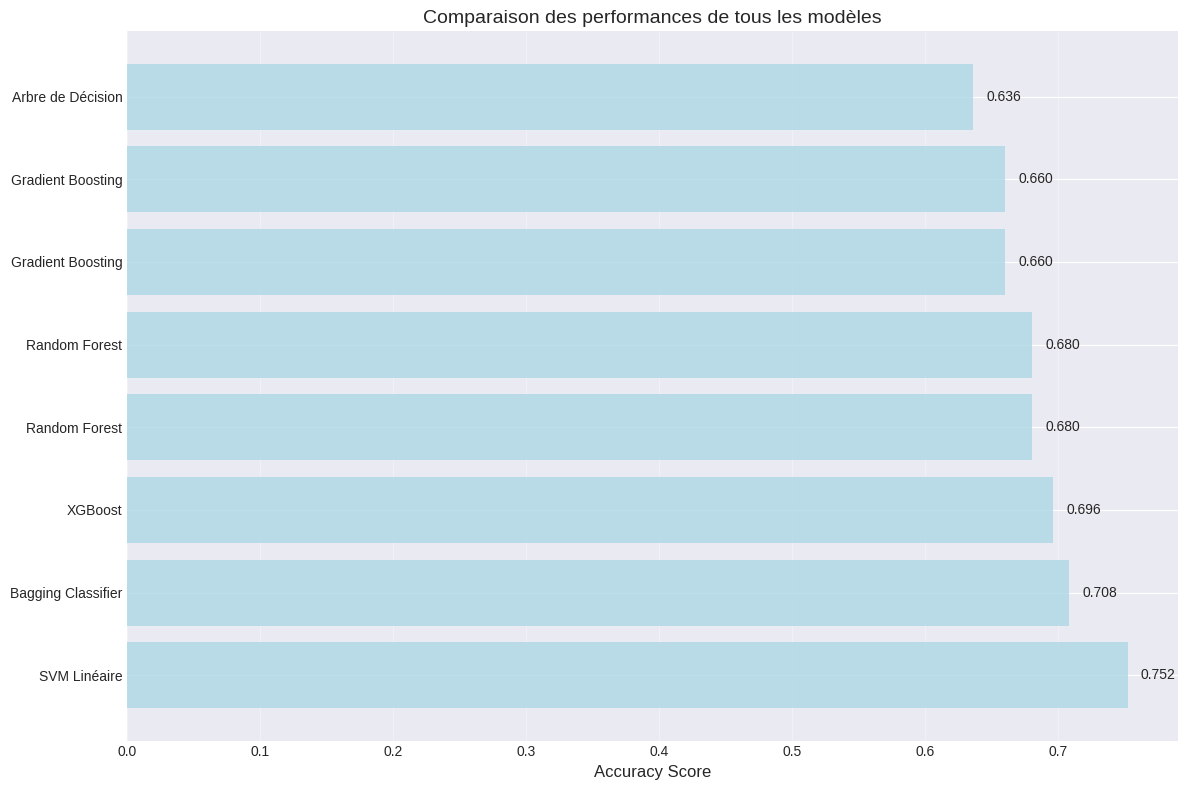

In [79]:
# Visualisation comparative
plt.figure(figsize=(12, 8))
models_plot = all_results['Modèle']
x_pos = np.arange(len(models_plot))

plt.barh(x_pos, all_results['Accuracy Test'], color='lightblue', alpha=0.8)
plt.yticks(x_pos, models_plot)
plt.xlabel('Accuracy Score', fontsize=12)
plt.title('Comparaison des performances de tous les modèles', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, v in enumerate(all_results['Accuracy Test']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

### **7.4 Feature Importance pour Random Forest**

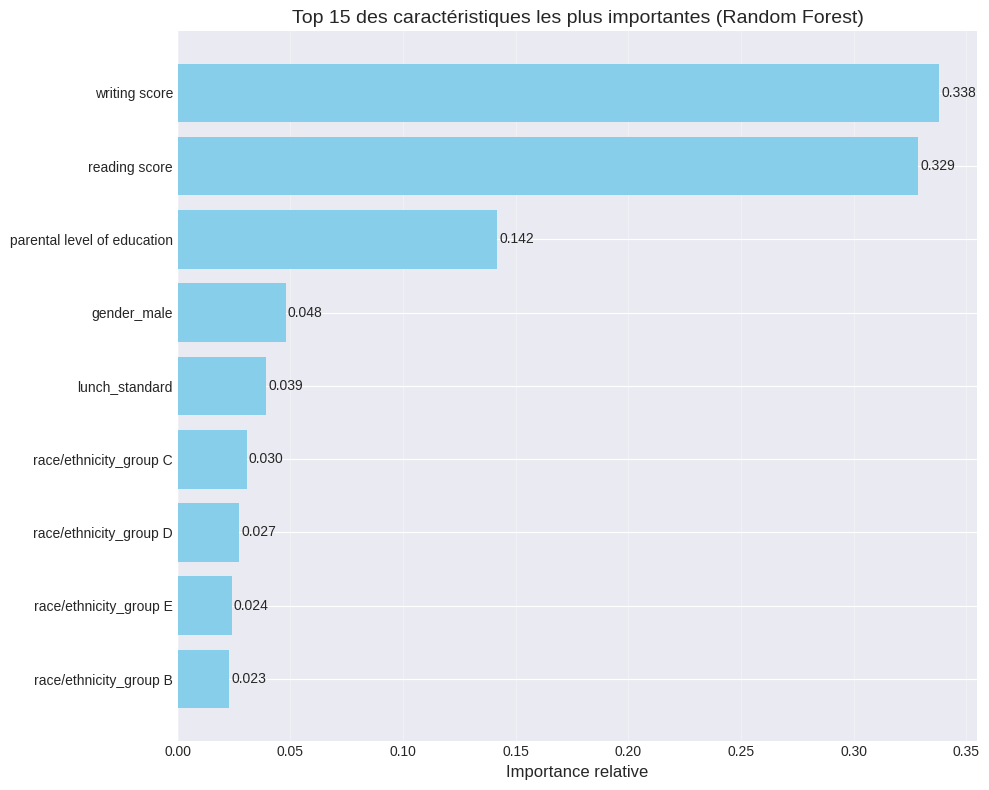

In [80]:
# Extraction des noms de features après prétraitement
feature_names = []
for transformer in preprocessor_clf.transformers_:
    if transformer[0] != 'remainder':
        if hasattr(transformer[1], 'get_feature_names_out'):
            feature_names.extend(transformer[1].get_feature_names_out())
        else:
            feature_names.extend([f"{transformer[0]}_{i}" for i in range(len(transformer[2]))])

# Obtenir le modèle Random Forest entraîné
rf_model = ensemble_models['Random Forest']

# Vérifier si le modèle a été entraîné
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    
    # Création d'un DataFrame pour l'importance des features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # S'assurer de la même longueur
        'Importance': importances
    })
    
    # Trier par importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(15)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
                   color='skyblue')
    plt.xlabel('Importance relative', fontsize=12)
    plt.title('Top 15 des caractéristiques les plus importantes (Random Forest)', fontsize=14)
    plt.gca().invert_yaxis()  # Inverser pour avoir la plus importante en haut
    plt.grid(True, alpha=0.3, axis='x')
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Le modèle n'a pas d'attribut 'feature_importances_'")

### **7.5 Validation croisée pour les modèles d'ensemble**

In [81]:
# Validation croisée pour les modèles d'ensemble
cv_results_ensemble = {}
for name, model in ensemble_models.items():
    scores = cross_val_score(model, X_train_clf_processed, y_train_clf,
                            cv=5, scoring='accuracy', n_jobs=-1)
    cv_results_ensemble[name] = scores

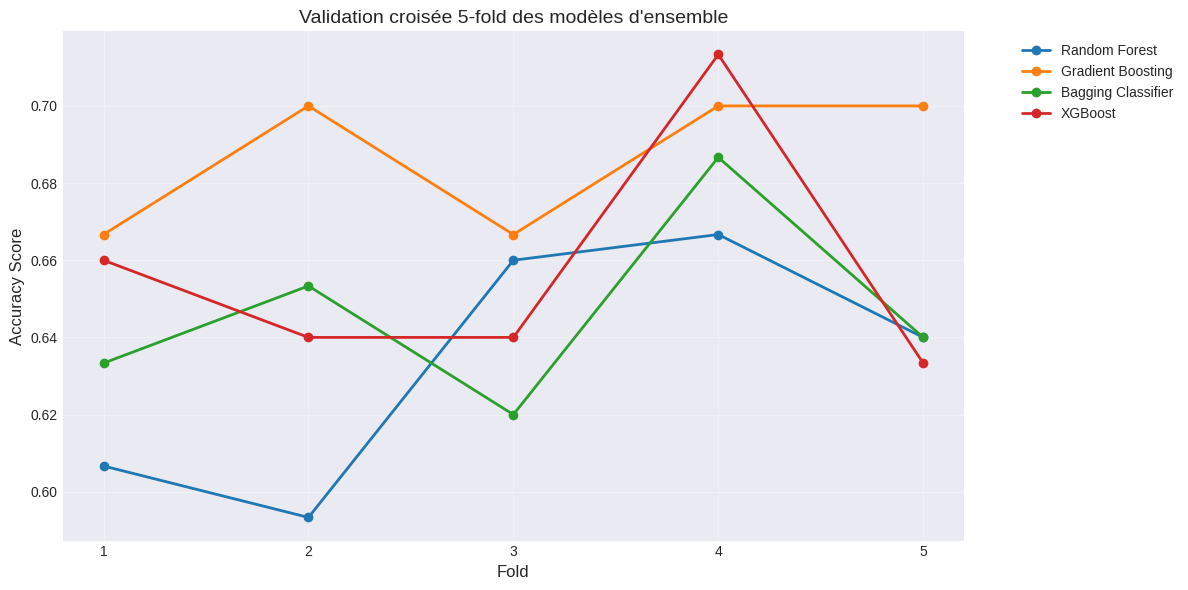

In [82]:
# Visualisation
plt.figure(figsize=(12, 6))
for name, scores in cv_results_ensemble.items():
    plt.plot(range(1, 6), scores, marker='o', linewidth=2, label=name)

plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Validation croisée 5-fold des modèles d\'ensemble', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()

In [83]:
# Résumé statistique
print("\nRésumé de la validation croisée pour les modèles d'ensemble:")
print("Moyenne ± Écart-type")
for name, scores in cv_results_ensemble.items():
    print(f"  {name}: {scores.mean():.3f} ± {scores.std():.3f}")


Résumé de la validation croisée pour les modèles d'ensemble:
Moyenne ± Écart-type
  Random Forest: 0.633 ± 0.029
  Gradient Boosting: 0.687 ± 0.016
  Bagging Classifier: 0.647 ± 0.023
  XGBoost: 0.657 ± 0.029


### **8. Conclusion et synthèse**

### **8.1 Synthèse des résultats**

In [84]:
print("=" * 70)
print("SYNTHÈSE DES RÉSULTATS DU PROJET")
print("=" * 70)

# Meilleur modèle de classification
best_clf = all_results.iloc[0]
print(f"\n1. MEILLEUR MODÈLE DE CLASSIFICATION:")
print(f"   Modèle: {best_clf['Modèle']}")
print(f"   Accuracy: {best_clf['Accuracy Test']:.3f}")
print(f"   F1-Score: {best_clf['F1-Score Test']:.3f}")

# Meilleur modèle de régression
best_reg = results_df_reg.iloc[0]
print(f"\n2. MEILLEUR MODÈLE DE RÉGRESSION:")
print(f"   Modèle: {best_reg['Modèle']}")
print(f"   R² Score: {best_reg['R² Test']:.3f}")
print(f"   RMSE: {best_reg['RMSE Test']:.2f}")

# Clustering
print(f"\n3. CLUSTERING (K-Means):")
print(f"   Nombre optimal de clusters: {optimal_k}")
print(f"   Score de silhouette: {silhouette_scores['K-Means']:.3f}")

# Observations importantes
print("\n4. OBSERVATIONS CLÉS:")
print("   - Forte corrélation entre les scores de lecture et d'écriture")
print("   - Les modèles d'ensemble surpassent généralement les modèles individuels")
print("   - La préparation au test influence positivement les performances")
print("   - Le niveau d'éducation des parents est un facteur important")

SYNTHÈSE DES RÉSULTATS DU PROJET

1. MEILLEUR MODÈLE DE CLASSIFICATION:
   Modèle: SVM Linéaire
   Accuracy: 0.752
   F1-Score: 0.603

2. MEILLEUR MODÈLE DE RÉGRESSION:
   Modèle: Lasso Regression
   R² Score: 0.869
   RMSE: 5.64

3. CLUSTERING (K-Means):
   Nombre optimal de clusters: 3
   Score de silhouette: 0.406

4. OBSERVATIONS CLÉS:
   - Forte corrélation entre les scores de lecture et d'écriture
   - Les modèles d'ensemble surpassent généralement les modèles individuels
   - La préparation au test influence positivement les performances
   - Le niveau d'éducation des parents est un facteur important


### **8.2 Visualisation finale de synthèse**

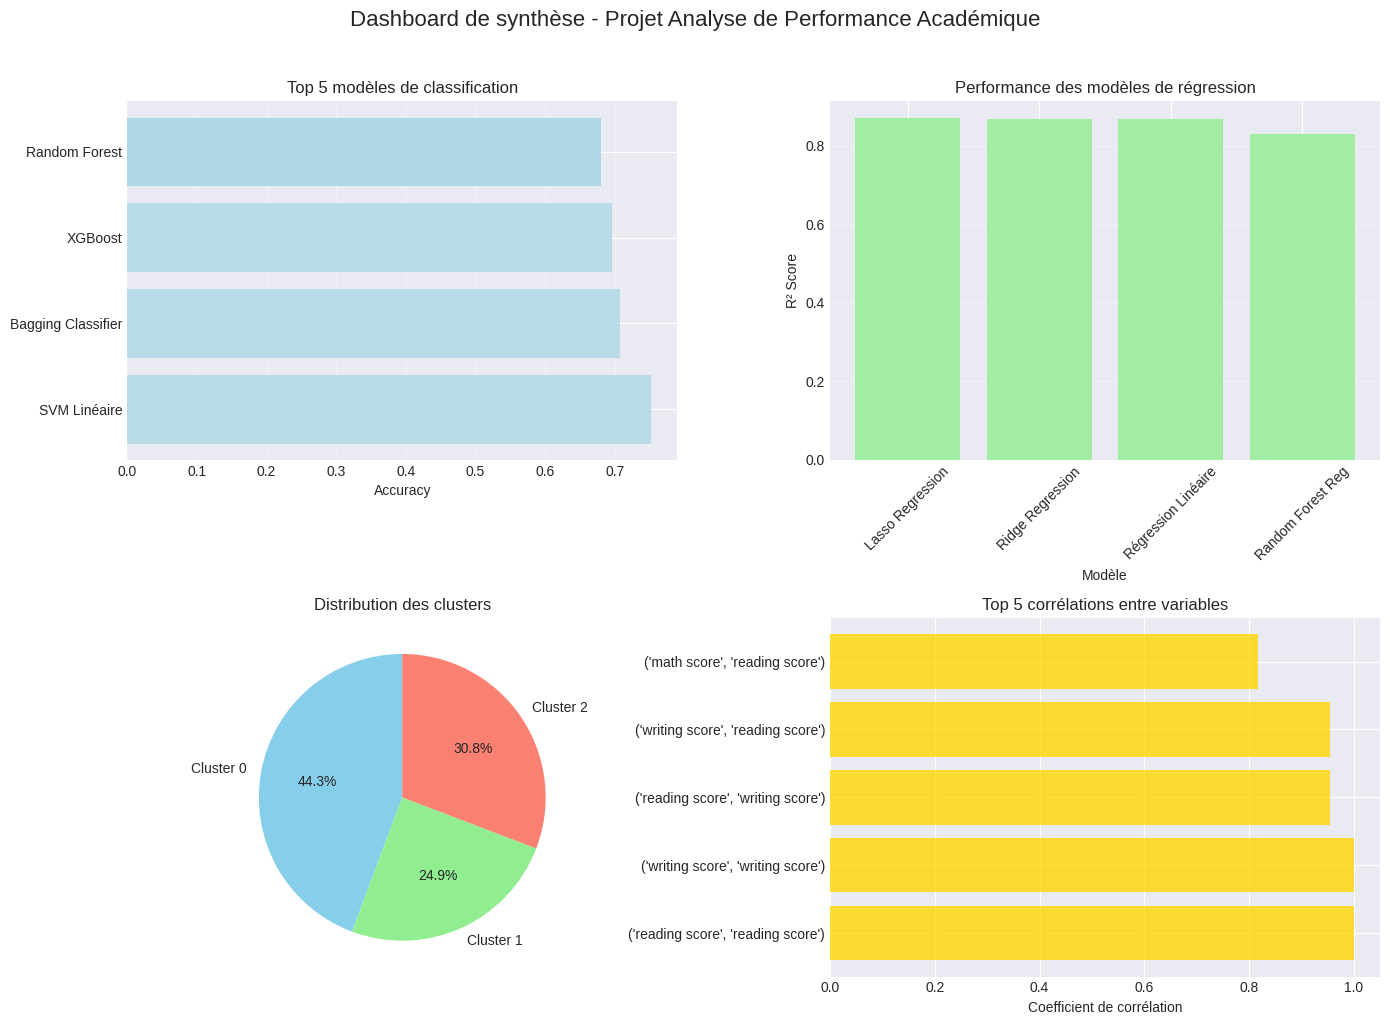

In [85]:
# Création d'un dashboard de synthèse
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Performance des modèles de classification
axes[0, 0].barh(all_results['Modèle'][:5], all_results['Accuracy Test'][:5], 
                color='lightblue', alpha=0.8)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Top 5 modèles de classification')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Performance des modèles de régression
axes[0, 1].bar(results_df_reg['Modèle'], results_df_reg['R² Test'], 
               color='lightgreen', alpha=0.8)
axes[0, 1].set_xlabel('Modèle')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Performance des modèles de régression')
axes[0, 1].set_xticklabels(results_df_reg['Modèle'], rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Distribution des clusters
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
axes[1, 0].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
               autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'salmon'])
axes[1, 0].set_title('Distribution des clusters')

# 4. Corrélation entre variables
corr_top = correlation_matrix.stack().nlargest(6).iloc[1:]  # Exclure la corrélation parfaite
axes[1, 1].barh([str(idx) for idx in corr_top.index], corr_top.values, 
                color='gold', alpha=0.8)
axes[1, 1].set_xlabel('Coefficient de corrélation')
axes[1, 1].set_title('Top 5 corrélations entre variables')

plt.suptitle('Dashboard de synthèse - Projet Analyse de Performance Académique', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **8.3 Sauvegarde des résultats**

In [86]:
# Sauvegarde des données importantes
import pickle

# Création d'un dictionnaire de résultats
results_summary = {
    'classification_results': all_results,
    'regression_results': results_df_reg,
    'clustering_results': {
        'optimal_k': optimal_k,
        'silhouette_score': silhouette_scores['K-Means'],
        'cluster_distribution': df_clustered['Cluster'].value_counts().to_dict()
    },
    'best_models': {
        'classification': best_clf['Modèle'],
        'regression': best_reg['Modèle']
    }
}

# Sauvegarde des résultats
with open('../models/project_results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("\n= Résultats sauvegardés dans 'project_results_summary.pkl'")
print("=" * 70)


= Résultats sauvegardés dans 'project_results_summary.pkl'
